# Comparing approaches to forecasting species richness using the Breeding Bird Survey

This project attempts to develop and evaluate a variety of approaches to making relatively short-term forecasts for patterns of species richness in the Breeding Bird Survey of North America data (BBS). BBS is being used as a starting point to develop these forecasts for community ecology more generally.

Forecasting methods currently being used include:

* Naive (last observed value in the time-series)
* Long-term average of value
* ARIMA models
* Spatial environmental linear models (currently just MODIS NDVI)
* Temporal environmental linear models (i.e., regressions fit to time-series at focal site; currently just MODIS NDVI)

Additional modeling approaches to be added include:

* Stacked single-species SDMs
* Joint SDMs
* spatio-temporal models?
* model averaging

In [1]:
library(forecast)
library(Hmisc)
library(dplyr)
library(broom)
library(ggplot2)
library(tidyr)
library(mgcv)
library(lme4)
library(caret)
library(gridExtra)
devtools::load_all()

library(sp)
library(raster)
library(maptools)
library(rgeos)
library(rgdal)
library(maps)
library(viridis)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: grid
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2
Warning message:
: replacing previous import by ‘ggplot2::unit’ when loading ‘Hmisc’Warning message:
: replacing previous import by ‘ggplot2::arrow’ when loading ‘Hmisc’Warning message:
: replacing previous import by ‘scales::alpha’ when loading ‘Hmisc’
Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    combine, src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

 

## Initial data setup

Load the BBS data and limit it to sites with contiguous time-series from 2000 to 2014 (the range spanned by the MODIS data).

In [2]:
start_yr <- 1982
end_yr <- 2013
min_num_yrs <- 25
richness_w_env <- get_richness_ts_env_data(start_yr, end_yr, min_num_yrs)

In [3]:
head(richness_w_env)
cat("There are", length(unique(richness_w_env$site_id)), "time-series with at least", min_num_yrs, "years of data between", start_yr, "and", end_yr)

Source: local data frame [6 x 28]

  site_id  year      lat      long richness     bio1     bio2     bio4  bio5
    (int) (dbl)    (dbl)     (dbl)    (int)    (dbl)    (dbl)    (dbl) (dbl)
1    2001  1982 34.86869 -87.60414       49 15.61292 12.14583 765.1609 32.16
2    2001  1983 34.86869 -87.60414       49 15.09625 12.04250 878.9235 34.43
3    2001  1984 34.86869 -87.60414       65 15.85250 12.64833 781.2187 31.32
4    2001  1985 34.86869 -87.60414       54 15.53250 11.97000 890.2069 31.51
5    2001  1986 34.86869 -87.60414       54 16.46875 12.54750 807.5210 34.10
6    2001  1987 34.86869 -87.60414       58 16.22125 13.25250 820.2997 34.53
Variables not shown: bio6 (dbl), bio12 (dbl), bio13 (dbl), bio14 (dbl), bio15
  (dbl), bio7 (dbl), bio3 (dbl), bio8 (dbl), bio9 (dbl), bio10 (dbl), bio11
  (dbl), bio16 (dbl), bio17 (dbl), bio18 (dbl), bio19 (dbl), ndvi_sum (dbl),
  ndvi_win (dbl), ndvi_ann (dbl), elevs (dbl)

There are 669 time-series with at least 25 years of data between 1982 and 2013

## Maps of variables

In [4]:
states <- map_data("state")
map_year = 2009 #pick a year to map

richness_w_env_oneyear <- dplyr::filter(richness_w_env, year == map_year) %>%
  na.omit()
map_richness <- ggplot() +
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="black", fill="white") +
  geom_point(data=richness_w_env_oneyear, aes(x=long, y=lat, color=richness)) +
  scale_color_viridis() +
  coord_map()

env_oneyear_long <- tidyr::gather(richness_w_env_oneyear, env_var, value, bio1:elevs)
maps_env_vars <- env_oneyear_long %>%
  group_by(env_var) %>%
  do(plots=ggplot() +
    geom_polygon(data=states, aes(x=long, y=lat, group=group), color="black", fill="white") +
    geom_point(data=., aes(x=long, y=lat, color=value)) +
    scale_color_viridis() +
    coord_map() +
    ggtitle(first(.$env_var))
    )
multi_panel_fig <- do.call("arrangeGrob", c(maps_env_vars$plots, ncol=4))
ggsave("figures/map_env_vars.png", multi_panel_fig, width = 20, height = 20)

### Map of Richness

![](figures/map_richness.png)

### Map of Environmental Variables

![](figures/map_env_vars.png)

## Forecasting

Generate forecasts for naive, average, and ARIMA time-series models for each site.

In [5]:
lag <- 10
richness_by_site <- group_by(richness_w_env, site_id)
tsmodel_forecasts <- get_ts_forecasts(richness_by_site, timecol = 'year',
                                      responsecol = 'richness',
                                      exogcol = "ndvi_ann", lag = lag)
head(tsmodel_forecasts)

Source: local data frame [6 x 9]

  site_id model timeperiod   obs pt_fcast     lo80     hi80     lo95     hi95
    (int) (chr)      (dbl) (int)    (dbl)    (dbl)    (dbl)    (dbl)    (dbl)
1    2001 naive       2004    58       63 55.39762 70.60238 51.37317 74.62683
2    2001 naive       2005    56       63 52.24862 73.75138 46.55718 79.44282
3    2001 naive       2006    62       63 49.83230 76.16770 42.86174 83.13826
4    2001 naive       2007    60       63 47.79525 78.20475 39.74634 86.25366
5    2001 naive       2008    59       63 46.00057 79.99943 37.00162 88.99838
6    2001 naive       2009    55       63 44.37806 81.62194 34.52020 91.47980

## Spatial environment-richness model prediction

### White & Hurlbert 2010 linear model

In [6]:
richness_w_env_2003 <- filter(richness_w_env, year == 2003)
richness_w_env_pre_2004 <- filter(richness_w_env, year <= 2003)
richness_w_env_2004_2013 <- filter(richness_w_env, year >= 2004)
spatial_bioclim_model_2003 <- lm(richness ~ bio10 + I(bio10^2) + bio11 +
                      I(bio11^2) + bio12 + I(bio12^2), data = richness_w_env_2003)
spatial_env_model_2003 <- lm(richness ~ ndvi_sum + I(ndvi_sum^2) + ndvi_win + I(ndvi_win^2) + bio10 + I(bio10^2) + bio11 +
                      I(bio11^2) + bio12 + I(bio12^2) + elevs + I(elevs^2), data = richness_w_env_pre_2004)
fcast_spatial_bioclim <- forecast(spatial_bioclim_model_2003, newdata = richness_w_env_2004_2013)
fcast_spatial_env <- forecast(spatial_env_model_2003, newdata = richness_w_env_2004_2013)
fcast_spatial_bioclim_data <- cbind(richness_w_env_2004_2013, fcast_spatial_bioclim)
fcast_spatial_env_data <- cbind(richness_w_env_2004_2013, fcast_spatial_env)
fcast_spatial_bioclim <- fcast_spatial_bioclim_data[, c("site_id", "year", "richness", "Point Forecast", "Lo 80", "Hi 80", "Lo 95", "Hi 95")]
fcast_spatial_env <- fcast_spatial_env_data[, c("site_id", "year", "richness", "Point Forecast", "Lo 80", "Hi 80", "Lo 95", "Hi 95")]
colnames(fcast_spatial_bioclim) <- c("site_id", "timeperiod", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
colnames(fcast_spatial_env) <- c("site_id", "timeperiod", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
fcast_spatial_bioclim$model <- 'spat_bioclim'
fcast_spatial_env$model <- 'spat_env'
fcast_spatial_bioclim <- dplyr::select(fcast_spatial_bioclim, site_id, model, everything())
fcast_spatial_env <- dplyr::select(fcast_spatial_env, site_id, model, everything())
head(fcast_spatial_env)

site_id    model timeperiod obs pt_fcast     lo80     hi80     lo95     hi95
1    2001 spat_env       2004  58 50.85210 39.52245 62.18175 33.52418 68.18002
2    2001 spat_env       2005  56 48.36500 37.04047 59.68953 31.04491 65.68508
3    2001 spat_env       2006  62 48.52880 37.20441 59.85319 31.20893 65.84868
4    2001 spat_env       2007  60 48.20163 36.87743 59.52583 30.88204 65.52121
5    2001 spat_env       2008  59 51.46744 40.14371 62.79116 34.14859 68.78628
6    2001 spat_env       2009  55 50.97243 39.64560 62.29925 33.64883 68.29602

### GAM

In [7]:
high_corr_vars <- colnames(richness_w_env_pre_2004)[findCorrelation(cor(richness_w_env_pre_2004, use = "complete.obs"))]
cat("The following highly correlated variables are remove from GAM & LME modeling: ", high_corr_vars)

The following highly correlated variables are remove from GAM & LME modeling:  bio11 bio1 bio7 bio16

#### Environmental smoothers

In [8]:
spatial_env_gam_model <- gam(richness ~ s(ndvi_sum, bs = "ts") + s(ndvi_win, bs = "ts") + s(elevs, bs = "ts") +
                            s(bio2, bs = "ts") + s(bio3, bs = "ts") + s(bio4, bs = "ts") + s(bio5, bs = "ts") + s(bio6, bs = "ts") +
                            s(bio8, bs = "ts") + s(bio9, bs = "ts") + s(bio10, bs = "ts") + s(bio12, bs = "ts") + s(bio13, bs = "ts") +
                            s(bio14, bs = "ts") + s(bio15, bs = "ts") + s(bio17, bs = "ts") + s(bio18, bs = "ts") + s(bio19, bs = "ts"),
                            family = gaussian, data = richness_w_env_pre_2004
                            )
pt_fcast <- predict(spatial_env_gam_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_gam <- dplyr::select(fcast_spatial_env, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_gam") %>%
  cbind(pt_fcast, lo80 = NA, hi80 = NA, lo95 = NA, hi95 = NA)

#### Spatial smoother

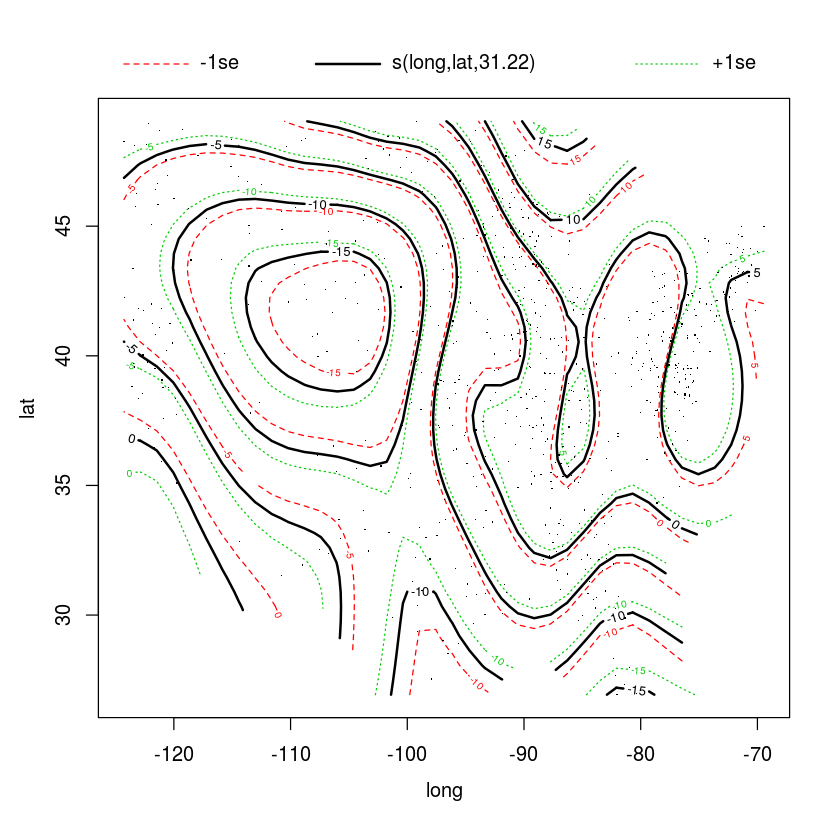

In [9]:
spatial_env_gam_spatial_model <- gam(richness ~ ndvi_sum + ndvi_win + elevs +
                            bio2 + bio3 + bio4 + bio5 + bio6 + 
                            bio8 + bio9 + bio10 + bio12 + bio13 +
                            bio14 + bio15 + bio17 + bio18 + bio19 +
                            s(long, lat, bs = "ds"),
                            family = gaussian, data = richness_w_env_pre_2004
                            )
pt_fcast <- predict(spatial_env_gam_spatial_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_gam_spatial <- dplyr::select(fcast_spatial_env, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_gam_spat") %>%
  cbind(pt_fcast, lo80 = NA, hi80 = NA, lo95 = NA, hi95 = NA)
plot(spatial_env_gam_spatial_model)

### Linear mixed-effects

In [10]:
spatial_env_lme_model <- lmer(richness ~ ndvi_sum + ndvi_win + elevs +
                              bio2 + bio3 + bio4 + bio5 + bio6 + 
                              bio8 + bio9 + bio10 + bio12 + bio13 +
                              bio14 + bio15 + bio17 + bio18 + bio19 + (1|site_id),
                              data = richness_w_env_pre_2004)
pt_fcast <- predict(spatial_env_lme_model, newdata = richness_w_env_2004_2013)
fcast_spatial_env_lme <- dplyr::select(fcast_spatial_env, site_id, model, timeperiod, obs) %>%
  mutate(model="spat_env_lme") %>%
  cbind(pt_fcast, lo80 = NA, hi80 = NA, lo95 = NA, hi95 = NA)

Warning message:
: Some predictor variables are on very different scales: consider rescaling

In [11]:
summary(spatial_env_lme_model)
var(richness_w_env_pre_2004$richness, na.rm = TRUE)

Linear mixed model fit by REML ['lmerMod']
Formula: richness ~ ndvi_sum + ndvi_win + elevs + bio2 + bio3 + bio4 +  
    bio5 + bio6 + bio8 + bio9 + bio10 + bio12 + bio13 + bio14 +  
    bio15 + bio17 + bio18 + bio19 + (1 | site_id)
   Data: richness_w_env_pre_2004

REML criterion at convergence: 82740.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4463 -0.5709  0.0154  0.6035  4.8789 

Random effects:
 Groups   Name        Variance Std.Dev.
 site_id  (Intercept) 89.42    9.456   
 Residual             22.58    4.752   
Number of obs: 13382, groups:  site_id, 669

Fixed effects:
              Estimate Std. Error t value
(Intercept) 53.3834821  2.6635921  20.042
ndvi_sum    10.6434279  1.3076618   8.139
ndvi_win     6.4567462  1.2412912   5.202
elevs       -0.0048659  0.0007963  -6.111
bio2         0.1225478  0.1695800   0.723
bio3        -0.1453126  0.0566397  -2.566
bio4         0.0020200  0.0011260   1.794
bio5        -0.3384564  0.0714537  -4.737
bio6         0.220

[1] 137.3854


## Assembling forecasts from different approaches

In [12]:
forecasts <- bind_rows(tsmodel_forecasts, fcast_spatial_env, fcast_spatial_env_gam, fcast_spatial_env_gam_spatial, fcast_spatial_env_lme) %>%
  group_by(site_id) %>%
  filter(min(timeperiod) == 2004, max(timeperiod) == 2013) #a couple of sites have missing environmental data for forecast years, which is currently breaking things a little

## Example single site forecast

### General notes

* rapid changes in S not uncommon in last five years
* common for last 5 years S vs. NDVI relationship to differ subsustantially from first 20 years

[1] 60027


Warning message:
: Removed 5 rows containing missing values (geom_point).

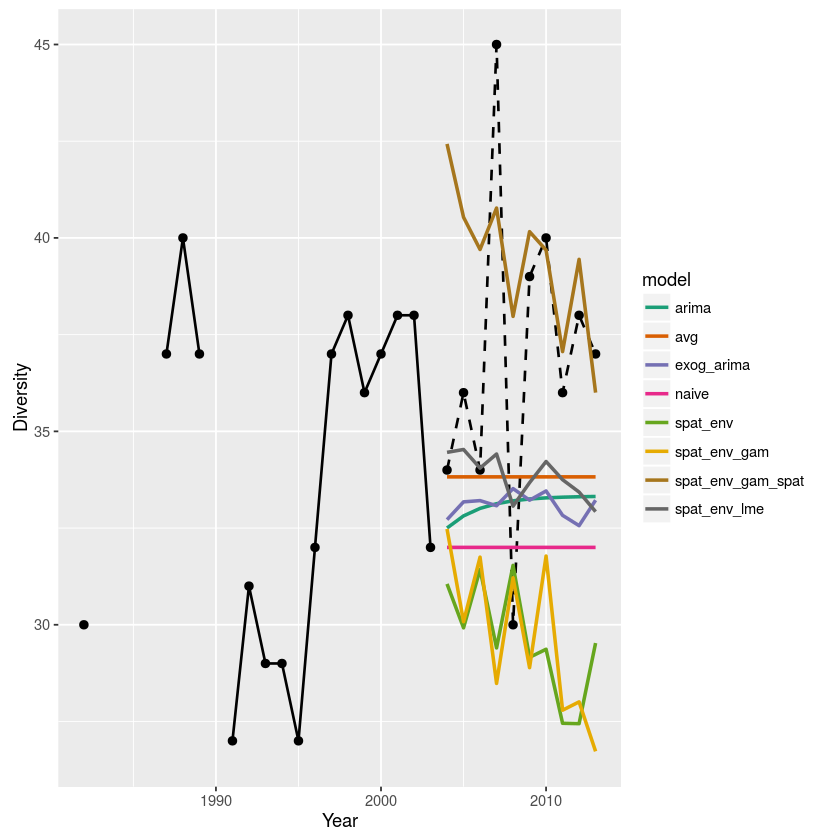

In [13]:
sites <- unique(richness_w_env$site_id)
focal_site <- sample(sites, 1)
print(focal_site)
viz_forecast(richness_w_env, forecasts, focal_site)

## Comparison of forecasting approaches

In [14]:
obs_pred_by_method_lag <- ggplot(forecasts, aes(x = pt_fcast, y = obs)) +
    geom_point(alpha = 0.25) +
    facet_grid(model ~ timeperiod) +
    theme(aspect.ratio = 1) +
    ggtitle("Observed-predicted plots by method and lag")
ggsave("figures/obs_pred_by_method_lag.png", obs_pred_by_method_lag)

Saving 7 x 7 in image
Warning message:
: Removed 4080 rows containing missing values (geom_point).

![](figures/obs_pred_by_method_lag.png)

In [15]:
model_accuracies <- group_by(forecasts, site_id, model) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies, 10)

Source: local data frame [10 x 7]
Groups: site_id, model [10]

   site_id             model          ME      RMSE       MAE        MPE
     (int)             (chr)       (dbl)     (dbl)     (dbl)      (dbl)
1     2001             arima  2.50000000  4.382921  3.320000  3.8779728
2     2001               avg  2.50000000  4.382921  3.320000  3.8779728
3     2001        exog_arima  0.09645321  4.914345  3.717689 -0.2743121
4     2001             naive -3.80000000  5.234501  4.600000 -6.8022524
5     2001          spat_env  9.08970585  9.760624  9.089706 15.0784051
6     2001      spat_env_gam  8.80532783  9.724378  8.805328 14.6062487
7     2001 spat_env_gam_spat  4.68750441  5.963752  4.881451  7.5881108
8     2001      spat_env_lme  2.32133256  4.241366  3.297615  3.5834392
9     2007             arima 10.54545455 12.347332 10.545455 18.0192177
10    2007               avg 10.54545455 12.347332 10.545455 18.0192177
Variables not shown: MAPE (dbl)

In [16]:
cbPalette <- c("#F0E442", "#D55E00", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#999999", "#CC79A7")
# rearranged from http://www.cookbook-r.com/Graphs/Colors_%28ggplot2%29/#a-colorblind-friendly-palette

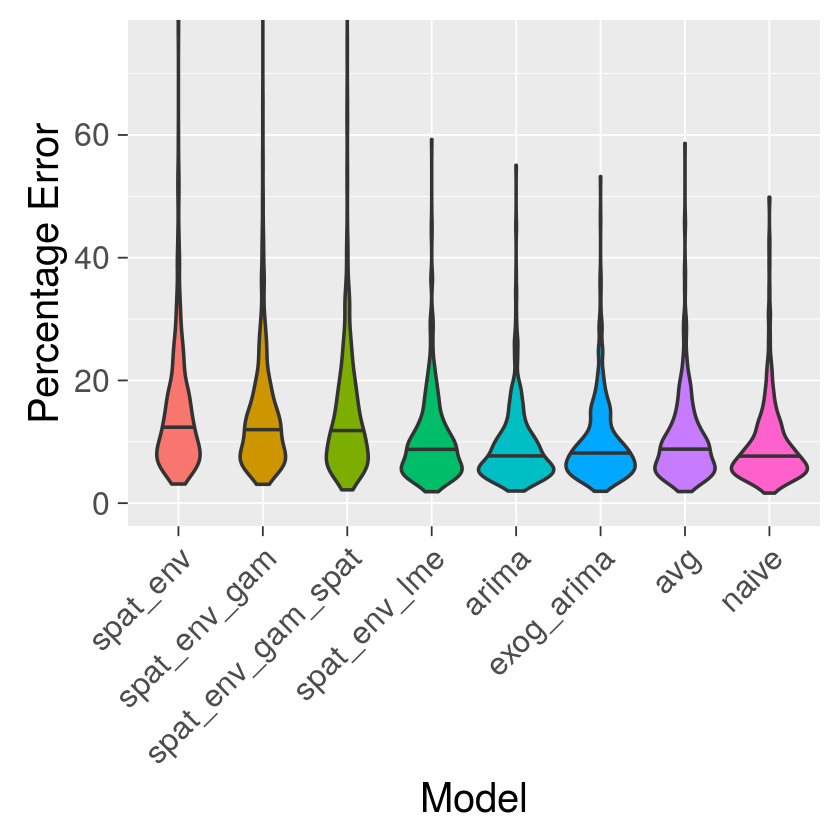

In [17]:
model_accuracies$model = with(model_accuracies, factor(model, levels = c("spat_env", "spat_env_gam", "spat_env_gam_spat", "spat_env_lme", "arima", "exog_arima", "avg", "naive")))
accuracy_by_model_violins <- ggplot(model_accuracies, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
     #scale_x_discrete(labels=c("Spatial Env", "Spatial Env GAM", "Spatial Env GAM Spatial", "Spatial Env LME", "Time-series", "Time-series+Env", "Average", "Naive")) +
     scale_color_brewer("Dark2") + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave(accuracy_by_model_violins, file = 'accuracy_by_model_violins.png', width = 7, height = 7)
accuracy_by_model_violins

In [18]:
model_accuracies_by_year <- group_by(forecasts, site_id, model, timeperiod) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
model_accuracies_by_year$model = with(model_accuracies_by_year, factor(model))
head(model_accuracies_by_year)

Source: local data frame [6 x 8]
Groups: site_id, model, timeperiod [6]

  site_id  model timeperiod    ME  RMSE   MAE       MPE     MAPE
    (int) (fctr)      (dbl) (dbl) (dbl) (dbl)     (dbl)    (dbl)
1    2001  arima       2004   1.3   1.3   1.3  2.241379 2.241379
2    2001  arima       2005  -0.7   0.7   0.7 -1.250000 1.250000
3    2001  arima       2006   5.3   5.3   5.3  8.548387 8.548387
4    2001  arima       2007   3.3   3.3   3.3  5.500000 5.500000
5    2001  arima       2008   2.3   2.3   2.3  3.898305 3.898305
6    2001  arima       2009  -1.7   1.7   1.7 -3.090909 3.090909

Warning message:
: Removed 4080 rows containing non-finite values (stat_summary).Warning message:
: Removed 510 rows containing non-finite values (stat_summary).Warning message:
: Removed 4080 rows containing non-finite values (stat_summary).Warning message:
: Removed 510 rows containing non-finite values (stat_summary).

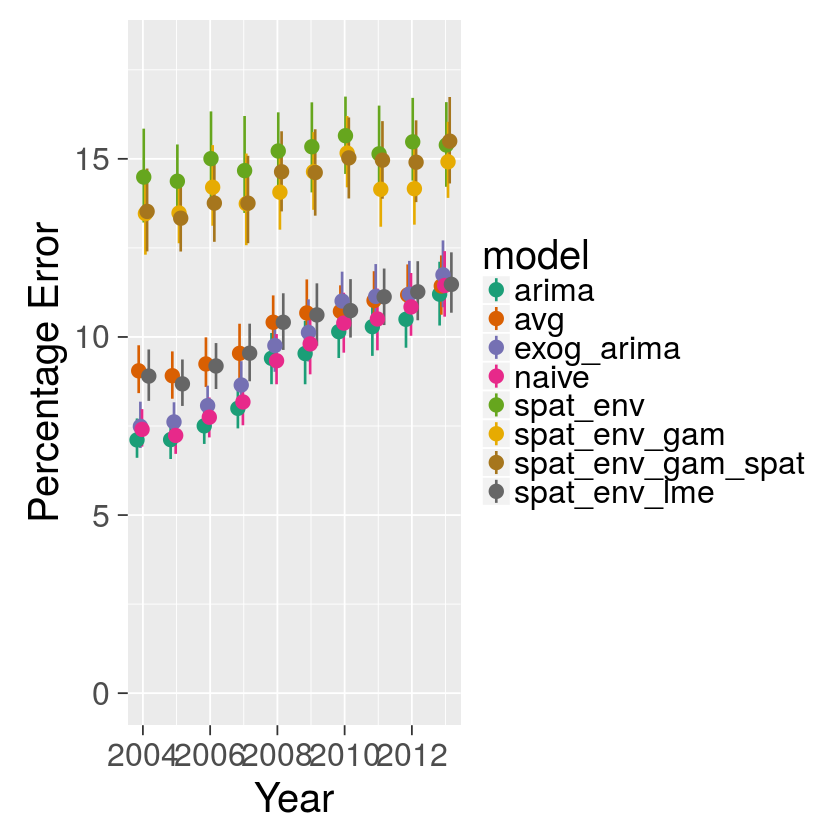

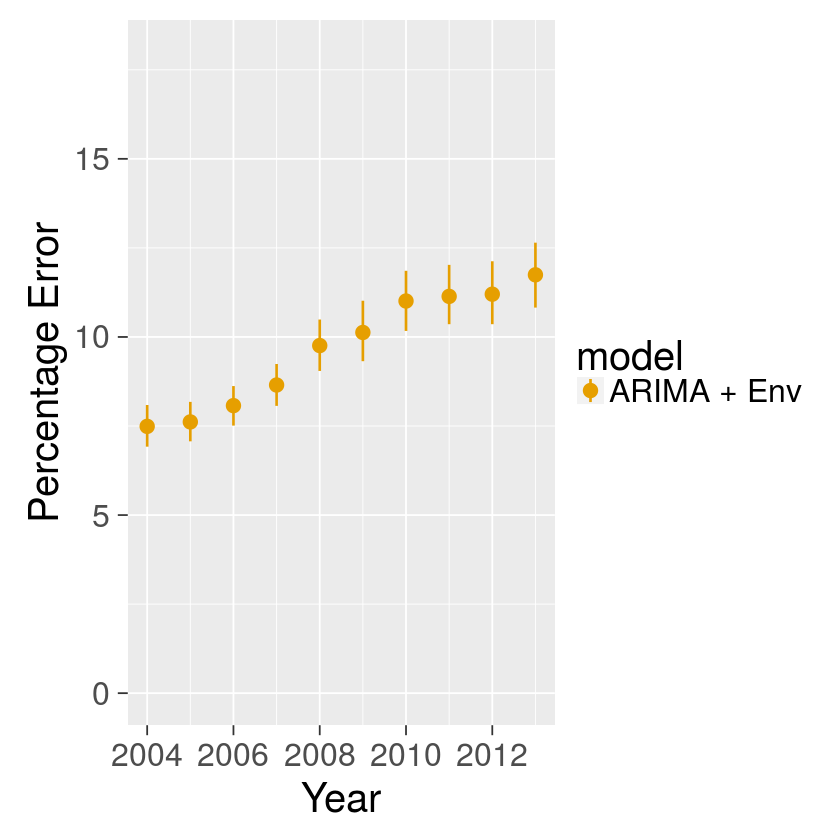

In [19]:
#ggplot(model_accuracies_by_year, aes(x = year, y = MAPE, color = model)) + stat_summary(fun.data = "mean_cl_boot")
model_accuracies_by_year_plot <- ggplot(model_accuracies_by_year, aes(x = timeperiod, y = MAPE, color = model)) +
    stat_summary(fun.data = "mean_cl_boot", position=position_dodge(width = 0.4), size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(0, 18), xlim = c(2004,2013)) +
     #scale_shape_discrete(labels=c("Spatial Env", "ARIMA", "ARIMA + Env", "Average", "Naive")) +
     #scale_color_manual(values = cbPalette, labels=c("Spatial Env", "ARIMA", "ARIMA + Env", "Average", "Naive")) + 
     scale_color_brewer(palette = "Dark2") +
     theme_grey(base_size = 24)
     #theme(legend.justification=c(1,0), legend.position=c(1,0))
ggsave(model_accuracies_by_year_plot, file = "model_accuracies_by_year.png", height = 5, width = 7)

arima_results <- filter(model_accuracies_by_year, model == 'exog_arima')
model_accuracies_by_year_arima_plot <- ggplot(arima_results, aes(x = timeperiod, y = MAPE, color = model)) +
     stat_summary(fun.data = "mean_cl_boot", size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(0, 18), xlim = c(2004,2013)) +
     scale_shape_discrete(labels=c("ARIMA + Env")) +
     scale_color_manual(values = cbPalette[3], labels=c("ARIMA + Env")) + 
     theme_grey(base_size = 24)

ggsave(model_accuracies_by_year_arima_plot, file = "arima_accuracies_by_year.png", height = 5, width = 7)

model_accuracies_by_year_plot
model_accuracies_by_year_arima_plot

## Forecast Coverage

Evaluate how well the 95% forecast intervals work

In [20]:
pred_interval_results <- forecasts %>%
                           group_by(model) %>%
                           na.omit() %>%
                           summarize(cov95 = sum(obs > lo95 & obs < hi95) / n(),
                                     cov80 = sum(obs > lo80 & obs < hi80) / n())
pred_interval_results

Source: local data frame [5 x 3]

       model     cov95     cov80
       (chr)     (dbl)     (dbl)
1      arima 0.8559353 0.7118705
2        avg 0.8437050 0.6352518
3 exog_arima 0.8253597 0.6789568
4      naive 0.9787770 0.9161871
5   spat_env 0.9419065 0.7807554

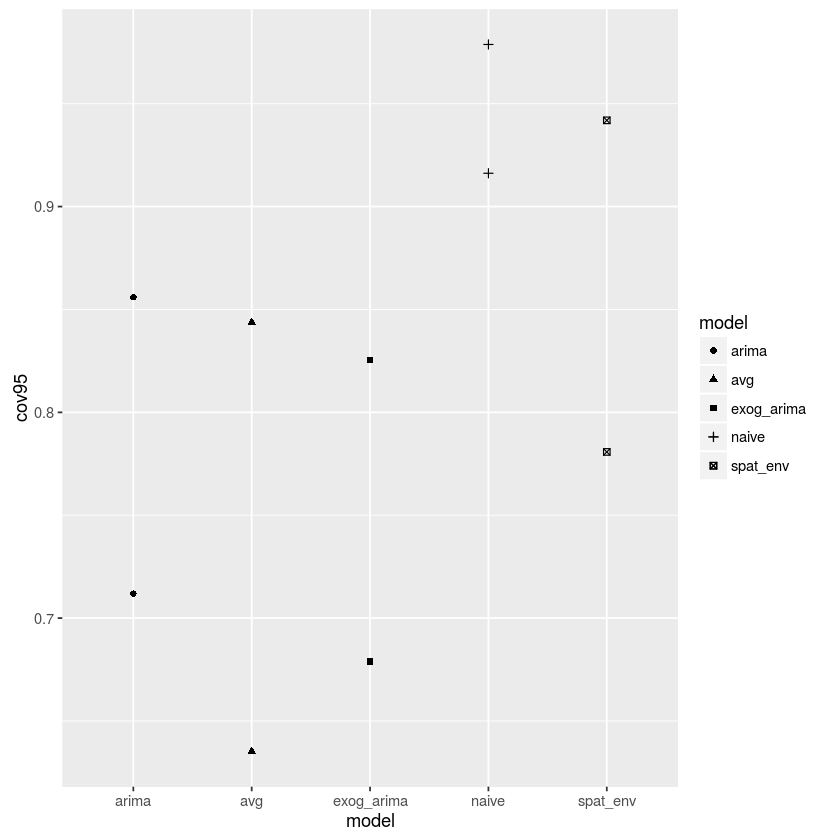

In [21]:
ggplot(pred_interval_results, aes(x = model, y = cov95, shape = model)) +
  geom_point() + 
  geom_point(aes(x = model, y = cov80))

## Trends in Richness & Environment

In [22]:
trends <- richness_w_env %>%
  group_by(site_id) %>%
  na.omit() %>%
  summarize(trend_rich = cor(richness, year), trend_ndvi_ann = cor(ndvi_ann, year), ndvi_rich_corr = cor(richness, ndvi_ann))
head(trends)

Source: local data frame [6 x 4]

  site_id trend_rich trend_ndvi_ann ndvi_rich_corr
    (int)      (dbl)          (dbl)          (dbl)
1    2001  0.3501663      0.6648884     0.14431650
2    2007  0.7086010      0.5167732     0.22745672
3    2010  0.7316861      0.6438039     0.51428194
4    2014  0.2679702      0.5370923     0.10646332
5    2015  0.3213840      0.3299191     0.37954197
6    2017 -0.4071651      0.6562717    -0.09613597

Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


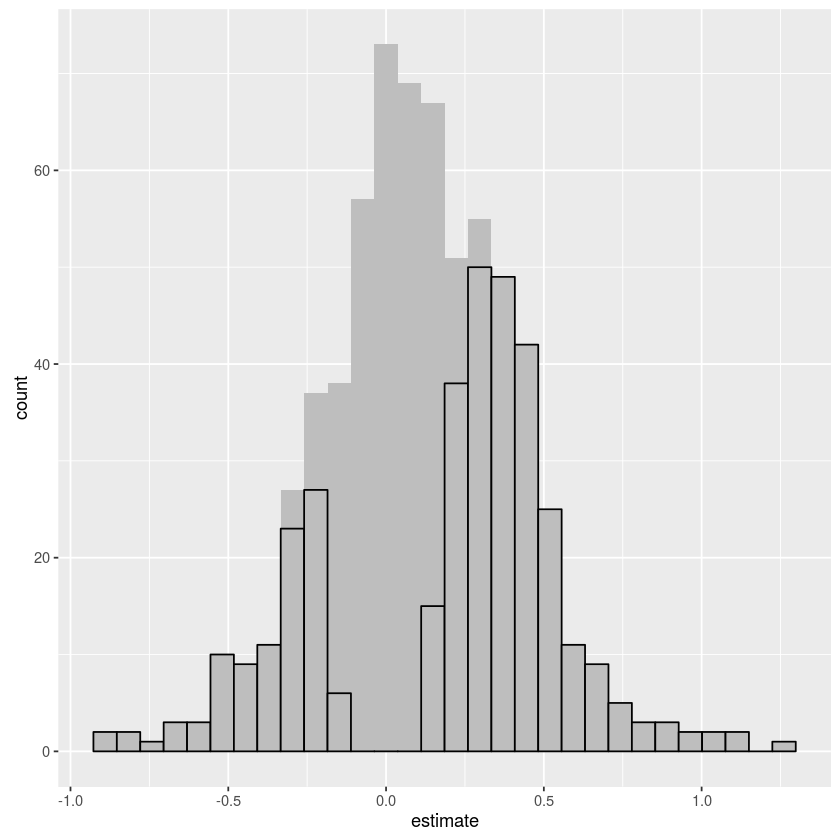

In [23]:
trends <- richness_w_env %>%
  group_by(site_id) %>%
  na.omit() %>%
  do(tidy(lm(richness ~ year, data = .))) %>%
  filter(term == 'year')
trends$adj_pval <- p.adjust(trends$p.value, method = 'fdr')
trends_rich_plot <- ggplot(trends, aes(x = estimate)) +
  geom_histogram(fill = 'gray')
trends_rich_sig_plot <- ggplot(trends, aes(x = estimate)) +
  geom_histogram(fill = 'gray') + 
  geom_histogram(data = filter(trends, adj_pval < 0.05), fill = 'gray', color = 'black')

ggsave(trends_rich_plot, file = "trends_rich_plot.png")
ggsave(trends_rich_sig_plot, file = "trends_rich_sig_plot.png")
trends_rich_sig_plot

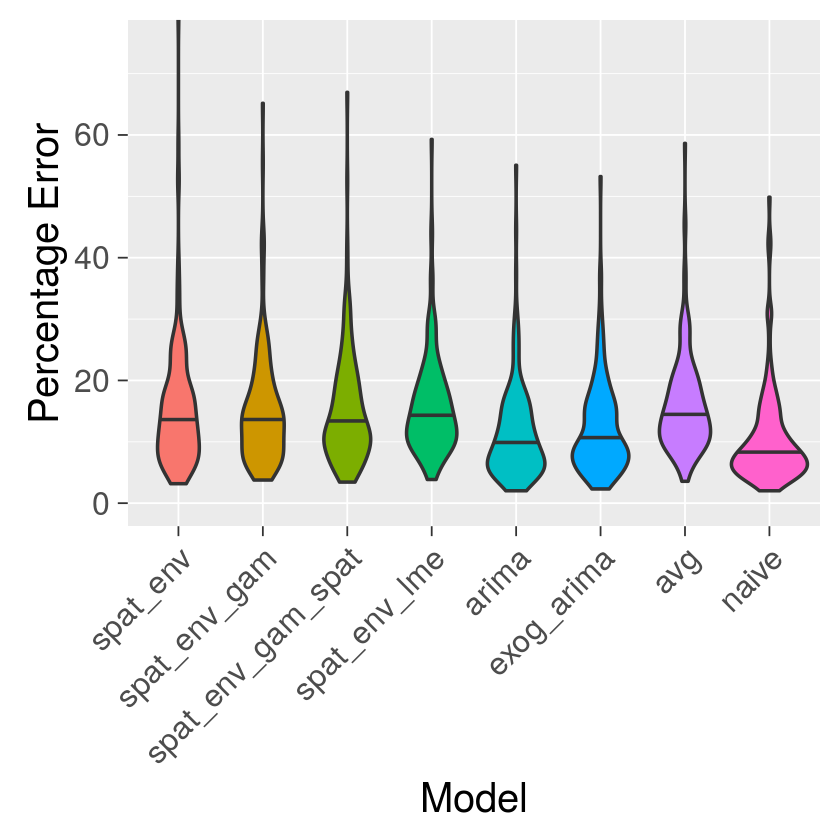

In [24]:
sig_sites <- trends %>%
  filter(adj_pval < 0.05, estimate > 0.333 | estimate < -0.333) %>%
  dplyr::select(site_id)
model_accuracies_sig <- filter(model_accuracies, site_id %in% sig_sites$site_id)

sig_accuracy_by_model_violins <- ggplot(model_accuracies_sig, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
#     scale_x_discrete(labels=c("Spatial Env", "Time-series", "Time-series+Env", "Average", "Naive")) +
#     scale_fill_manual(values = cbPalette) + 
     scale_color_brewer("Dark2") +
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave(sig_accuracy_by_model_violins, file = 'sig_accuracy_by_model_violins.png', width = 7, height = 7)
sig_accuracy_by_model_violins

## Comparison of bioclim and simple environmental model

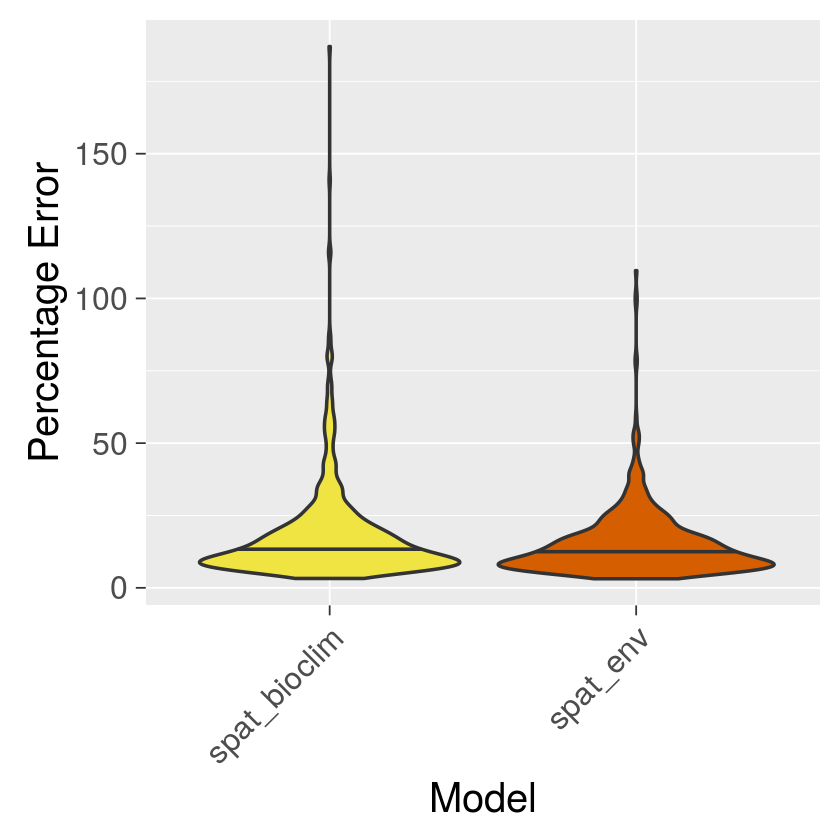

In [25]:
forecasts_spatial <- rbind(fcast_spatial_bioclim, fcast_spatial_env) %>%
  group_by(site_id) %>%
  filter(min(timeperiod) == 2004, max(timeperiod) == 2013)

model_accuracies_spatial <- group_by(forecasts_spatial, site_id, model) %>%
  do(get_error_measures(.$obs, .$pt_fcast))

ggplot(model_accuracies_spatial, aes(model, MAPE)) +
     geom_violin(aes(fill = model), draw_quantiles = c(0.5), size = 1) +
     #coord_cartesian(ylim = c(0,75)) +
     labs(x = "Model", y = "Percentage Error") +
     #scale_x_discrete(labels=c("Spatial Env", "Time-series", "Time-series+Env", "Average", "Naive")) +
     scale_fill_manual(values = cbPalette) + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

## Models combining spatial & temporal information

In [26]:
richness_w_env_prev_yr_rich <- richness_w_env %>%
  dplyr::select(site_id, year, prev_yr_rich=richness) %>%
  mutate(year = year + 1) %>%
  inner_join(richness_w_env, by = c("site_id", "year"))
head(richness_w_env_prev_yr_rich)

Source: local data frame [6 x 29]

  site_id  year prev_yr_rich      lat      long richness     bio1     bio2
    (int) (dbl)        (int)    (dbl)     (dbl)    (int)    (dbl)    (dbl)
1    2001  1983           49 34.86869 -87.60414       49 15.09625 12.04250
2    2001  1984           49 34.86869 -87.60414       65 15.85250 12.64833
3    2001  1985           65 34.86869 -87.60414       54 15.53250 11.97000
4    2001  1986           54 34.86869 -87.60414       54 16.46875 12.54750
5    2001  1987           54 34.86869 -87.60414       58 16.22125 13.25250
6    2001  1988           58 34.86869 -87.60414       65 15.46167 13.32833
Variables not shown: bio4 (dbl), bio5 (dbl), bio6 (dbl), bio12 (dbl), bio13
  (dbl), bio14 (dbl), bio15 (dbl), bio7 (dbl), bio3 (dbl), bio8 (dbl), bio9
  (dbl), bio10 (dbl), bio11 (dbl), bio16 (dbl), bio17 (dbl), bio18 (dbl), bio19
  (dbl), ndvi_sum (dbl), ndvi_win (dbl), ndvi_ann (dbl), elevs (dbl)

In [27]:
spatial_statespace_model_1983 <- gam(richness ~ prev_yr_rich + s(ndvi_sum) + s(ndvi_win) + s(elevs) +
                                  s(bio1) + s(bio2) + s(bio3) + s(bio4) + s(bio5) + s(bio6) + s(bio7) +
                                  s(bio8) + s(bio9) + s(bio10) + s(bio11) + s(bio12) + s(bio13) +
                                  s(bio14) + s(bio15) + s(bio16) + s(bio17) + s(bio18) + s(bio19),
                                  family = gaussian, data = richness_w_env_prev_yr_rich
                                 )

summary(spatial_statespace_model_1983)


Family: gaussian 
Link function: identity 

Formula:
richness ~ prev_yr_rich + s(ndvi_sum) + s(ndvi_win) + s(elevs) + 
    s(bio1) + s(bio2) + s(bio3) + s(bio4) + s(bio5) + s(bio6) + 
    s(bio7) + s(bio8) + s(bio9) + s(bio10) + s(bio11) + s(bio12) + 
    s(bio13) + s(bio14) + s(bio15) + s(bio16) + s(bio17) + s(bio18) + 
    s(bio19)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.043804   0.214599   37.48   <2e-16 ***
prev_yr_rich 0.848615   0.004015  211.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(ndvi_sum) 6.721  7.819 13.891  < 2e-16 ***
s(ndvi_win) 8.225  8.832  8.568 1.06e-12 ***
s(elevs)    5.128  6.280  4.423 0.000146 ***
s(bio1)     6.382  7.589  2.703 0.007633 ** 
s(bio2)     2.993  3.935  1.660 0.201304    
s(bio3)     4.709  5.945  2.488 0.021164 *  
s(bio4)     2.460  3.283  1.552 0.189240    
s(bio